# EDA | Exploring more questions
---
---

# Imports

#### Standard library imports

In [2]:
import sys
sys.path.append("../../")

#### Third party imports

In [3]:
import pandas as pd
import seaborn as sns

#### Local application imports

In [4]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

# Extracting data

In [5]:
## Function parameters
db_crds = 'pc_db_prod'
sql_files_path = '../../pkg_dir/sql/'
sql_script = 'appointments.sql'
sql_params = sql_params_appointments

In [6]:
dfx = sql_to_df(db_crds, sql_files_path, sql_script, sql_params)

# Manipulating data

In [7]:
## Reference to simplify labels in appointment status
values_map = {
    
    'COMPLETADA': 'completed',
    'SALA_ESPERA': 'completed',
    'CONSULTA': 'completed',
    'CONFIRMADO_PAGO': 'completed',

    'NO_PRESENTO': 'no_show',
    'MENSAJE_DEJADO': 'no_show',
    'NO_CONFIRMADO': 'no_show',
    'CONFIRMADO': 'no_show',
    'LLEGA_TARDE_ESPERA': 'no_show',
    'REAGENDAR': 'no_show',
    
}

In [8]:
## Mapping values according to reference
dfx['appointment_status_simple'] = dfx['appointment_status'].map(values_map).fillna(dfx['appointment_status'])

In [24]:
dfx

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,appointment_status_simple
0,2022859913,2023-02-24,10:30,11:00,24/01/2023 10:30:59,COMPLETADA,DRA ANDREA RODRIGUEZ ALVAREZ DE LA CUADRA,GINECOLOGIA,COAPA,149388,1998-11-05,completed
1,2022967719,2023-01-24,13:00,13:30,23/01/2023 17:44:44,NO_PRESENTO,DR. Daniel Bernardo De Uranga Cuervo,OTORRINOLARINGOLOGIA,CUAJIMALPA,197993,2001-06-03,no_show
2,2023223297,2023-02-05,12:30,13:00,01/02/2023 07:25:52,COMPLETADA,DRA LITZAHAYA FLORES GARCIA,OTORRINOLARINGOLOGIA,MARINA NACIONAL,200120,1992-10-21,completed
3,2023120283,2023-02-02,17:00,17:30,28/01/2023 08:08:51,COMPLETADA,DR. JUAN SALVADOR GARCIA MATURANO,REUMATOLOGIA,CUAJIMALPA,197081,1956-01-02,completed
4,2022864335,2023-01-25,11:00,11:30,18/01/2023 09:52:58,COMPLETADA,DR. EDGAR ALEJANDRO MEDRANO,UROLOGIA,COAPA,193534,1958-04-02,completed
...,...,...,...,...,...,...,...,...,...,...,...,...
163562,2023000309785,2023-01-31,09:30,10:00,30/01/2023 15:47:45,NO_PRESENTO,Mariana Sarao Pineda,DERMATOLOGIA,MARINA NACIONAL,199722,2001-08-31,no_show
163563,2022864355,2023-01-30,08:30,09:00,23/01/2023 12:11:14,COMPLETADA,DR. EDGAR ALEJANDRO MEDRANO,UROLOGIA,COAPA,49289,1991-05-14,completed
163564,2023000289091,2023-01-24,11:30,12:00,23/01/2023 13:07:16,COMPLETADA,DR. FERNANDO ENRIQUE TOVAR GARCIA,GASTROENTEROLOGIA,TLALPAN,191527,1934-03-05,completed
163565,2023000283567,2023-02-06,08:00,08:30,30/01/2023 16:14:45,COMPLETADA,DR. Fernando Iván Vergara Orduña,CARDIOLOGIA,MONTEVIDEO,199731,1997-07-07,completed


# Solving questions

### What was the no-show rate in 2023?

In [8]:
dfx['appointment_status_simple'].value_counts()

appointment_status_simple
completed    138186
no_show       25380
Name: count, dtype: int64

In [9]:
dfx['appointment_status_simple'].value_counts(normalize=True)

appointment_status_simple
completed    0.844833
no_show      0.155167
Name: proportion, dtype: float64

### No-show rate in 2023 segmented per clinic

In [10]:
## Grouping data by clinic
dfy = dfx.loc[:, ['appointment_id', 'appointment_status_simple', 'clinic']].groupby(
    [
        'clinic',
        'appointment_status_simple',
    ],
    # as_index=False
).agg(
    {
        'appointment_id': 'count'
    }
)

## Renaming aggregate column
dfy.rename(columns={'appointment_id': 'count'}, inplace=True)

In [11]:
## Adding new column with proportions per clinic
dfy["proportion"] = dfy['count']/dfy.groupby(["clinic"])["count"].transform("sum")

In [12]:
dfy

count  proportion
clinic          appointment_status_simple                   
BASILICA        completed                  36186    0.821905
                no_show                     7841    0.178095
COAPA           completed                  31480    0.865929
                no_show                     4874    0.134071
CUAJIMALPA      completed                  12510    0.870200
                no_show                     1866    0.129800
DEL VALLE       completed                   5505    0.827820
                no_show                     1145    0.172180
DOCTORES        completed                   2170    0.826982
                no_show                      454    0.173018
MARINA NACIONAL completed                  17939    0.845980
                no_show                     3266    0.154020
MONTEVIDEO      completed                   8182    0.867564
                no_show                     1249    0.132436
TLALPAN         completed                  24214    0.837884
                no_show                     4685    0.162116

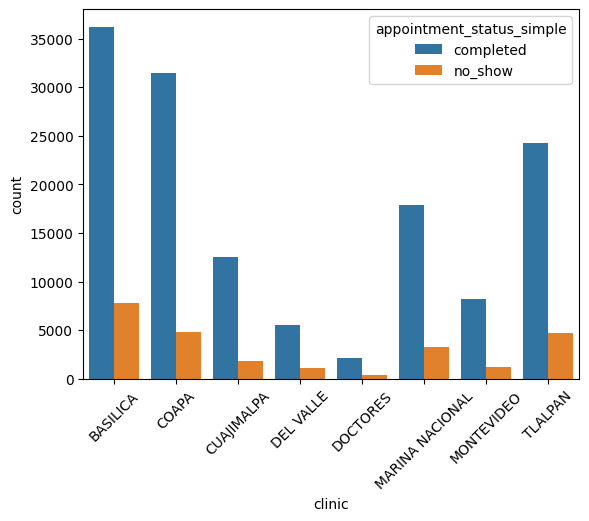

In [13]:
plt = sns.barplot(
    dfy, 
    x="clinic", 
    y="count", 
    hue="appointment_status_simple", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

### No-show rate in 2023 segmented per month

In [51]:
## Selecting a subset of columns for data analysis

dfz = dfx.loc[:, ['appointment_id', 'appointment_date', 'appointment_status_simple']]

## Converting appointment_date to datetime format, then extract month and month number (for sorting)

dfz['appointment_date'] = pd.to_datetime(dfz['appointment_date'])
dfz['month_number'] = dfz['appointment_date'].dt.month
dfz['month'] = dfz['appointment_date'].dt.strftime('%B')

## Grouping no show rates by month

rate_by_month = dfz.loc[:, ['appointment_id', 'appointment_status_simple', 'month', 'month_number']].groupby(
    [
        'month',
        'month_number',
        'appointment_status_simple',
    ],
).agg(
    {
        'appointment_id': 'count'
    }
)
#Sorts months in chronological order instead of alphabetical order, then drop month_number column

rate_by_month.sort_values(by = 'month_number', inplace = True)
rate_by_month = rate_by_month.droplevel('month_number')

## Renaming aggregate column
rate_by_month.rename(columns={'appointment_id': 'count'}, inplace=True)

## Adding new column with proportions per month
rate_by_month['proportion'] = rate_by_month['count']/rate_by_month.groupby(["month"])["count"].transform("sum")



In [52]:
rate_by_month

count  proportion
month     appointment_status_simple                   
January   completed                  10236    0.821707
          no_show                     2221    0.178293
February  completed                   9280    0.830202
          no_show                     1898    0.169798
March     no_show                     2048    0.153927
          completed                  11257    0.846073
April     completed                  10510    0.840128
          no_show                     2000    0.159872
May       no_show                     2254    0.162932
          completed                  11580    0.837068
June      no_show                     1920    0.143102
          completed                  11497    0.856898
July      no_show                     1925    0.139100
          completed                  11914    0.860900
August    no_show                     2067    0.137956
          completed                  12916    0.862044
September completed                  12089    0.850978
          no_show                     2117    0.149022
October   completed                  12544    0.841936
          no_show                     2355    0.158064
November  completed                  12886    0.847931
          no_show                     2311    0.152069
December  no_show                     2264    0.164762
          completed                  11477    0.835238

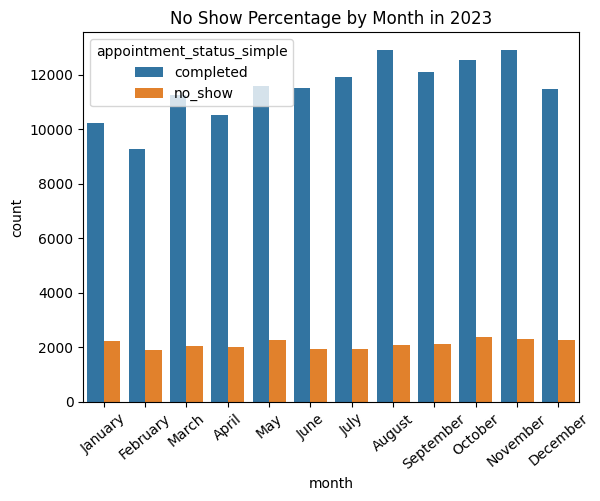

In [79]:
plt = sns.barplot(
    rate_by_month, 
    x="month", 
    y="count", 
    hue="appointment_status_simple"
    )
plt.set(title = "No Show Percentage by Month in 2023")

for item in plt.get_xticklabels():
    item.set_rotation(40)

###  With how much time in advance are the consultations scheduled? (overall and per specialty)

In [9]:
def filter_by_speciality(specialty):
    df_specialty = dfx[dfx['medical_specialty'] == specialty]
    df_s = df_specialty.loc[:, ['appointment_id', 'medical_specialty', 'appointment_date', 'appointment_creation', 'appointment_status_simple']]
    df_s['appointment_date'] = pd.to_datetime(df_s['appointment_date'],  format='%Y-%m-%d').dt.date
    df_s['appointment_creation'] = pd.to_datetime(df_s['appointment_creation'], dayfirst=False, format='mixed').dt.date
    days_difference = df_s['appointment_date']-df_s['appointment_creation']
    df_s['days_until_consultation'] = [d.days for d in days_difference]
    return df_s

    

In [98]:
specialties = set(dfx['medical_specialty'])
for s in specialties:
    print(filter_by_speciality(s))

         appointment_id medical_specialty appointment_date  \
335     2023000285338        OFTALMOLOGIA       2023-02-24   
440     2023000384054        OFTALMOLOGIA       2023-03-31   
706     2023000394403        OFTALMOLOGIA       2023-03-31   
768     2023000489017        OFTALMOLOGIA       2023-03-31   
993     2023000541344        OFTALMOLOGIA       2023-04-28   
...                 ...               ...              ...   
159202  2023214358           OFTALMOLOGIA       2023-01-27   
159415  2023000362386        OFTALMOLOGIA       2023-03-31   
159702  2023000527499        OFTALMOLOGIA       2023-05-26   
162722  2023000729582        OFTALMOLOGIA       2023-08-04   
162748  2023000729760        OFTALMOLOGIA       2023-08-11   

       appointment_creation appointment_status_simple  days_until_consultation  
335              2023-02-17                   no_show                        7  
440              2023-02-23                 completed                       36  
706         

In [11]:
df_q1 = dfx.loc[:, ['appointment_id', 'medical_specialty', 'appointment_date', 'appointment_creation', 'appointment_status_simple']]
df_q1['appointment_date'] = pd.to_datetime(df_q1['appointment_date'],  format='%Y-%m-%d').dt.date
df_q1['appointment_creation'] = pd.to_datetime(df_q1['appointment_creation'], dayfirst=False, format='mixed').dt.date

In [15]:
days_difference = df_q1['appointment_date']-df_q1['appointment_creation']
df_q1['days_until_consultation'] = [d.days for d in days_difference]

In [16]:
df_q1.sort_values(['medical_specialty', 'appointment_status_simple', 'days_until_consultation'])

,appointment_id,medical_specialty,appointment_date,appointment_creation,appointment_status_simple,days_until_consultation
56018,2023000742121,ALERGOLOGIA,2023-07-12,2023-12-07,completed,-148
33307,2023000742455,ALERGOLOGIA,2023-07-14,2023-12-07,completed,-146
45473,2023000742451,ALERGOLOGIA,2023-07-14,2023-11-07,completed,-116
20806,2023000742178,ALERGOLOGIA,2023-08-16,2023-12-08,completed,-114
93593,2023000742518,ALERGOLOGIA,2023-08-18,2023-12-08,completed,-112
...,...,...,...,...,...,...
68603,2023200600,Ultrasonido,2023-11-06,2023-03-11,no_show,240
26916,2023200593,Ultrasonido,2023-11-04,2023-02-11,no_show,266
20030,2022835662,Ultrasonido,2023-01-09,2022-04-11,no_show,273
35718,2022835655,Ultrasonido,2023-01-09,2022-04-11,no_show,273


### How many appointments are scheduled without any payment?

###  With how much time in advance are the appointments canceled?

###  How many of the patients receive a message/call to confirm their appointment?

###  What's the distribution of the scheduling channels? (phone, online)

### How many of the patients register a phone number?

# Notes

### Duplicated values

In [14]:
dfx.loc[dfx[['appointment_id']].duplicated(keep=False), :].sort_values('appointment_id')

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,appointment_status_simple
144524,2021170937,2023-10-11,11:00,11:30,16/08/2021 10:19:03,MENSAJE_DEJADO,DRA KARLA NOEMI SALAZAR VILLEGAS,DERMATOLOGIA,BASILICA,94937,1999-02-03,no_show
93682,2021170937,2023-10-11,11:00,11:30,16/08/2021 10:19:03,MENSAJE_DEJADO,DRA KARLA NOEMI SALAZAR VILLEGAS,DERMATOLOGIA,BASILICA,94937,1999-02-03,no_show
14152,2023000300922,2023-07-31,19:30,20:00,30/07/2023 09:02:21,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,165429,1969-01-06,completed
14017,2023000300922,2023-07-31,19:30,20:00,27/07/2023 10:16:46,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,165429,1969-01-06,completed
155723,2023000300993,2023-09-18,16:30,17:00,12/09/2023 17:00:52,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,255714,1997-06-27,completed
...,...,...,...,...,...,...,...,...,...,...,...,...
80280,2023138378,2023-12-22,08:30,09:00,21/12/2023 12:01:29,COMPLETADA,DR. Hector Javier Sotelo Reyna,NEUMOLOGIA,BASILICA,282656,1990-03-08,completed
39027,2023144492,2023-12-22,12:00,12:30,17/12/2023 15:27:12,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,243929,1960-03-17,completed
39911,2023144492,2023-12-22,12:00,12:30,21/12/2023 11:58:45,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,243929,1960-03-17,completed
129063,2023144498,2023-12-22,11:00,11:30,21/12/2023 11:57:58,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,282769,1967-11-18,completed


---

---